### Classification of FR abstracts as big data or not.

Uses TFIDF as vectorization and initial labeled dataset of 1200 abstracts.

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', 50)

#### Ingest Data - labeled set and full corpus

In [2]:
# read in initial training dataset - 1200 labeled abstracts
df_lab = pd.read_csv("../../../../data/prd/Digital_abstract_labelled/AUG-2022-labelled_abstracts.csv")
print(df_lab.shape)
df_lab.head()

(1200, 8)


,Unnamed: 0,Duplicates,index,PROJECT_ID,ABSTRACT,Is it related to Big-Data,Expert name,label
0,0,0,979,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Kristian,Big-data
1,1,0,816,1178172,Project Summary/AbstractThe establishment of t...,1,Kristian,Big-data
2,2,0,1096,163037,DESCRIPTION (provided by applicant): The long-...,0,Kristian,Non Big-data
3,3,0,725,880197,DESCRIPTION (provided by applicant): The most ...,0,Kristian,Non Big-data
4,4,0,92,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Kristian,Non Big-data


In [3]:
df_lab = df_lab[['PROJECT_ID','ABSTRACT','Is it related to Big-Data','label']]
df_lab.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,950056,ï»¿ DESCRIPTION (provided by applicant): Adv...,1,Big-data
1,1178172,Project Summary/AbstractThe establishment of t...,1,Big-data
2,163037,DESCRIPTION (provided by applicant): The long-...,0,Non Big-data
3,880197,DESCRIPTION (provided by applicant): The most ...,0,Non Big-data
4,887331,Transsphenoidal surgery (TSS) is the best trea...,0,Non Big-data


In [4]:
#data frame with all of the abstracts
df = pd.read_pickle("../../../../data/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")

# Reset the df index and create a variable index to link with PROJECT_ID
df.reset_index(inplace = True, drop = True)
print(df.shape)
df.head()

(1143869, 30)


,PROJECT_ID,ABSTRACT,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,FY_TOTAL_COST_SUM,NUM_RECORDS,final_tokens
0,89996,"This is a project to explore Game-based, Metap...",Achievement; analog; base; Cognitive Science; ...,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,NSF,NSF,NaN,0814512,9/15/2008,8/31/2012,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",01,068719400,WHEELING JESUIT UNIVERSITY,WHEELING,WV,26003-6243,UNITED STATES,NaN,NaN,47.076,2008,1999467.0,NaN,1,1,1999467.0,1,project explore game base metaphor enhanced ga...
1,89997,Institution: Franklin Institute Science Museum...,Active Learning; Child; Computer software; des...,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,NSF,NSF,NaN,0741659,9/15/2008,8/31/2012,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",02,001741859,FRANKLIN INSTITUTE,PHILADELPHIA,PA,19103-1115,UNITED STATES,NaN,NaN,47.076,2008,1799699.0,NaN,1,1,1799699.0,1,institution franklin institute science museum ...
2,89998,Through programs (including small group conver...,Address; Age; Birth; Brain; Caregivers; Child;...,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,NSF,NSF,NaN,0813522,9/15/2008,8/31/2011,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",04,061451670,SCIENCE MUSEUM OF MINNESOTA,SAINT PAUL,MN,55102-1202,UNITED STATES,NaN,NaN,47.076,2008,1505858.0,NaN,1,1,1505858.0,1,program include small group conversation citiz...
3,89999,In partnership with the American Chemical Soci...,Advanced Development; American; Chemicals; Che...,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,NSF,NSF,NaN,0838627,8/1/2008,12/31/2010,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",04,009059242,INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,DURHAM,NC,27709-3757,UNITED STATES,NaN,NaN,47.049,2008,51000.0,NaN,1,1,51000.0,1,partnership american chemical society acs nati...
4,90001,The Center for Molecular Interfacing (CMI) wil...,Address; Architecture; Carbon Nanotubes; Catal...,CCI PHASE I: CENTER FOR MOLECULAR INTERFACING,NSF,NSF,NaN,0847926,10/1/2008,9/30/2011,"ABRUNA, HECTOR D",NaN,22,872612445,CORNELL UNIVERSITY ITHACA,ITHACA,NY,14850-2820,UNITED STATES,NaN,NaN,47.049,2008,1519821.0,NaN,1,1,1519821.0,1,center molecular interfacing cmi enable integr...


In [5]:
df = df[['PROJECT_ID','ABSTRACT']]
df.head()

,PROJECT_ID,ABSTRACT
0,89996,"This is a project to explore Game-based, Metap..."
1,89997,Institution: Franklin Institute Science Museum...
2,89998,Through programs (including small group conver...
3,89999,In partnership with the American Chemical Soci...
4,90001,The Center for Molecular Interfacing (CMI) wil...


In [6]:
# merge with the labelled data using PROJECT_ID.
df['PROJECT_ID'] = pd.to_numeric(df['PROJECT_ID'])
df_merge = df.merge(df_lab[['PROJECT_ID','Is it related to Big-Data','label']], how='left', on='PROJECT_ID')
len(df_merge)

1143869

In [7]:
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN
2,89998,Through programs (including small group conver...,NaN,NaN
3,89999,In partnership with the American Chemical Soci...,NaN,NaN
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN


In [8]:
# Save project ID of labelled data
project_id_lab = list(df_lab['PROJECT_ID'])

# Get the index of labelled abstract
subset_df = df_merge.loc[df_merge['PROJECT_ID'].isin(project_id_lab),['PROJECT_ID','label']]

In [9]:
subset_df.head()

,PROJECT_ID,label
1050,91187,Non Big-data
1413,91311,Non Big-data
3557,93680,Big-data
4845,95339,Non Big-data
6670,97249,Non Big-data


In [10]:
# build training and testing sets from the labeled data 
# sklearn to find list of indices for training and test set

X_train_idx, X_test_idx, y_train_tfidf, y_test_tfidf = train_test_split(subset_df.index, 
                                                                        subset_df['label'].values, 
                                                                        test_size=0.20, random_state=0, 
                                                                        stratify=subset_df['label'].values)


### 1.1 TFIDF Vectorization

In [11]:
# Compute the TFIDF matrix on the full data
t1 = time.time()
v = TfidfVectorizer()
tfidf = v.fit_transform(df['ABSTRACT'])
t2 = time.time()

print(t2-t1)

229.91865754127502


In [12]:
tfidf

<1143869x1307953 sparse matrix of type '<class 'numpy.float64'>'
	with 213160046 stored elements in Compressed Sparse Row format>

In [13]:
# use training and testing set ids to create feature sets

X_train_tfidf = tfidf[X_train_idx,:]
X_test_tfidf = tfidf[X_test_idx,:]

## 1.2. KNN classifier

In [14]:
# number of neighbors
k = int(math.sqrt(len(y_train_tfidf)))
print('Number of neighbors:', k)

Number of neighbors: 30


In [15]:
# Run KNN

classifierKNN = KNeighborsClassifier(n_neighbors= k)  # njobs? don't need

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifierKNN, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifierKNN.fit(X_train_tfidf, y_train_tfidf)

# find model accuracy
classifierKNN.score(X_test_tfidf,y_test_tfidf)

[0.75       0.640625   0.63020833 0.703125   0.67708333]
Accuracy: 0.68.   Standard Deviation: 0.04


0.7166666666666667

In [16]:
# Predict the classification
y_pred_tfidf = classifierKNN.predict(X_test_tfidf)

In [17]:
# Classifier performance
confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print(confusion)
print(classification_report(y_test_tfidf, y_pred_tfidf))

[[95  2]
 [66 77]]
              precision    recall  f1-score   support

    Big-data       0.59      0.98      0.74        97
Non Big-data       0.97      0.54      0.69       143

    accuracy                           0.72       240
   macro avg       0.78      0.76      0.72       240
weighted avg       0.82      0.72      0.71       240



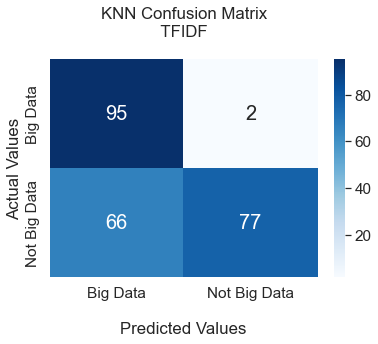

In [18]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('KNN Confusion Matrix\n TFIDF \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/tfidf_KNN.png', bbox_inches='tight')
plt.show()

In [19]:
# Predict the classification for the whole data: use the whole TFIDF
t1 = time.time()
y_tfidf = classifierKNN.predict(tfidf)
t2 = time.time()

print(t2-t1)

137.41508889198303


In [20]:
# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_KNN'] = y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Big-data


## 1.3. SVM

In [21]:
# We run SVM with default parameters provides by Sklearn. We train the model

classifier_svm = svm.SVC()

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_svm, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_svm.fit(X_train_tfidf, y_train_tfidf)

# find model accuracy
classifier_svm.score(X_test_tfidf,y_test_tfidf)

[0.859375   0.77604167 0.84895833 0.80729167 0.83333333]
Accuracy: 0.82.   Standard Deviation: 0.03


0.8041666666666667

In [22]:
# Predict the classification
y_pred_tfidf = classifier_svm.predict(X_test_tfidf)

In [23]:
# Classifier performance
confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print(confusion)
print(classification_report(y_test_tfidf, y_pred_tfidf))

[[ 64  33]
 [ 14 129]]
              precision    recall  f1-score   support

    Big-data       0.82      0.66      0.73        97
Non Big-data       0.80      0.90      0.85       143

    accuracy                           0.80       240
   macro avg       0.81      0.78      0.79       240
weighted avg       0.81      0.80      0.80       240



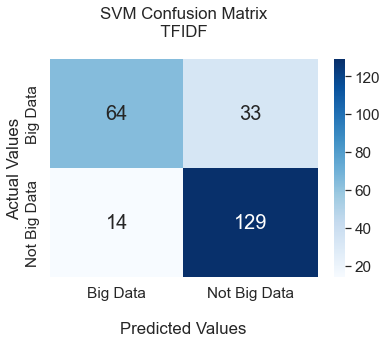

In [24]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('SVM Confusion Matrix\n TFIDF \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/tfidf_SVM.png', bbox_inches='tight')
plt.show()

In [25]:
# Predict the classification for the whole data: use the whole TFIDF
t1 = time.time()
y_tfidf = classifier_svm.predict(tfidf)
t2 = time.time()

print(t2-t1)

1534.774362564087


In [26]:
# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_SVM'] = y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Big-data,Non Big-data


## 1.4. Decision Tree

In [27]:
# Use default parameters provides by SKLearn and train the model
classifier_DT = DecisionTreeClassifier(random_state = 0)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_DT, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_DT.fit(X_train_tfidf, y_train_tfidf)

# find model accuracy
classifier_DT.score(X_test_tfidf,y_test_tfidf)

[0.84895833 0.734375   0.72916667 0.79166667 0.80729167]
Accuracy: 0.78.   Standard Deviation: 0.05


0.7875

In [28]:
# Predict the classification
y_pred_tfidf = classifier_DT.predict(X_test_tfidf)

In [29]:
# Classifier performance
confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print(confusion)
print(classification_report(y_test_tfidf, y_pred_tfidf))

[[ 68  29]
 [ 22 121]]
              precision    recall  f1-score   support

    Big-data       0.76      0.70      0.73        97
Non Big-data       0.81      0.85      0.83       143

    accuracy                           0.79       240
   macro avg       0.78      0.77      0.78       240
weighted avg       0.79      0.79      0.79       240



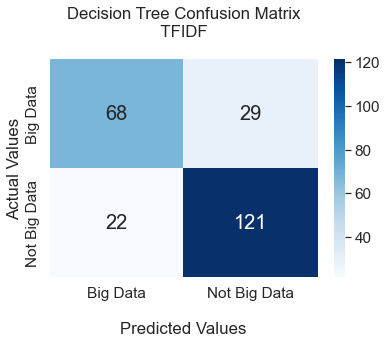

In [30]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Decision Tree Confusion Matrix\n TFIDF \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/tfidf_DT.png', bbox_inches='tight')
plt.show()

In [31]:
# Predict the classification for the whole data: use the whole TFIDF
t1 = time.time()
y_tfidf = classifier_DT.predict(tfidf)
t2 = time.time()

print(t2-t1)

1.9642884731292725


In [32]:
# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_DT'] = y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Big-data,Non Big-data,Non Big-data


## 1.5. Random Forest

In [33]:
# Use default parameters provides by SKLearn and train the model
classifier_RF = RandomForestClassifier(random_state=0)  # use njobs?

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_RF, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
classifier_RF.fit(X_train_tfidf, y_train_tfidf)

# find model accuracy
classifier_RF.score(X_test_tfidf,y_test_tfidf)

[0.83333333 0.77083333 0.76041667 0.765625   0.77604167]
Accuracy: 0.78.   Standard Deviation: 0.03


0.7791666666666667

In [34]:
# Predict the classification
y_pred_tfidf = classifier_RF.predict(X_test_tfidf)

In [35]:
# Classifier performance
confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print(confusion)
print(classification_report(y_test_tfidf, y_pred_tfidf))

[[ 57  40]
 [ 13 130]]
              precision    recall  f1-score   support

    Big-data       0.81      0.59      0.68        97
Non Big-data       0.76      0.91      0.83       143

    accuracy                           0.78       240
   macro avg       0.79      0.75      0.76       240
weighted avg       0.78      0.78      0.77       240



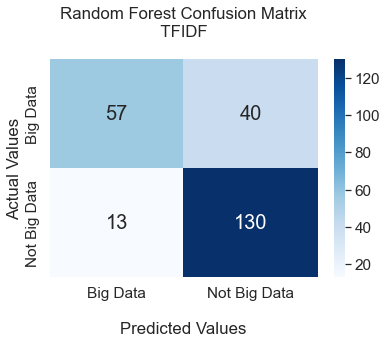

In [36]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Random Forest Confusion Matrix\n TFIDF \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/tfidf_RF.png', bbox_inches='tight')
plt.show()

In [37]:
# Predict the classification for the whole data: use the whole TFIDF
t1 = time.time()
y_tfidf = classifier_RF.predict(tfidf)
t2 = time.time()

print(t2-t1)

107.0326554775238


In [38]:
# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_RF'] = y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data


## 1.6. Neural network classifier

In [39]:
# Use default parameters provides by SKLearn and train the model
classifier_nn = MLPClassifier(random_state=0, verbose=True)

# cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(classifier_nn, X_train_tfidf, y_train_tfidf, scoring='accuracy', cv=cv)
print(scores)
print("Accuracy: %0.2f.   Standard Deviation: %0.2f" % (scores.mean(), scores.std()))

# train model after cross-validation
t1 = time.time()
classifier_nn.fit(X_train_tfidf, y_train_tfidf)
t2 = time.time()

print(t2-t1)

# find model accuracy
classifier_nn.score(X_test_tfidf,y_test_tfidf)

Iteration 1, loss = 0.70132992
Iteration 2, loss = 0.65652519
Iteration 3, loss = 0.60725482
Iteration 4, loss = 0.55646173
Iteration 5, loss = 0.50682573
Iteration 6, loss = 0.45837961
Iteration 7, loss = 0.41224324
Iteration 8, loss = 0.36852516
Iteration 9, loss = 0.32878286
Iteration 10, loss = 0.29280285
Iteration 11, loss = 0.26054941
Iteration 12, loss = 0.23188768
Iteration 13, loss = 0.20660787
Iteration 14, loss = 0.18449155
Iteration 15, loss = 0.16510116
Iteration 16, loss = 0.14804710
Iteration 17, loss = 0.13309989
Iteration 18, loss = 0.12038100
Iteration 19, loss = 0.10880066
Iteration 20, loss = 0.09892675
Iteration 21, loss = 0.09038329
Iteration 22, loss = 0.08271476
Iteration 23, loss = 0.07621069
Iteration 24, loss = 0.07036643
Iteration 25, loss = 0.06500139
Iteration 26, loss = 0.06067695
Iteration 27, loss = 0.05661424
Iteration 28, loss = 0.05290934
Iteration 29, loss = 0.04973489
Iteration 30, loss = 0.04687327
Iteration 31, loss = 0.04441871
Iteration 32, los

0.7958333333333333

In [40]:
# Predict the classification
y_pred_tfidf = classifier_nn.predict(X_test_tfidf)

In [41]:
# Classifier performance
confusion = confusion_matrix(y_test_tfidf, y_pred_tfidf)
print(confusion)
print(classification_report(y_test_tfidf, y_pred_tfidf))

[[ 70  27]
 [ 22 121]]
              precision    recall  f1-score   support

    Big-data       0.76      0.72      0.74        97
Non Big-data       0.82      0.85      0.83       143

    accuracy                           0.80       240
   macro avg       0.79      0.78      0.79       240
weighted avg       0.79      0.80      0.79       240



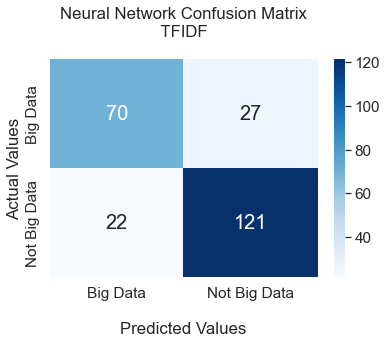

In [42]:
## Display the visualization of the Confusion Matrix.

sns.set(font_scale=1.4)
ax = sns.heatmap(confusion, annot=True, fmt="", cmap='Blues', xticklabels=["Big Data", "Not Big Data"], 
            annot_kws={"fontsize":20})
plt.title('Neural Network Confusion Matrix\n TFIDF \n') 
plt.xlabel('\nPredicted Values')
plt.ylabel('Actual Values') 
ax.set_yticklabels(['Big Data', 'Not Big Data'], va='center', rotation = 90) #position=(0,0.28))

plt.savefig('figures/tfidf_NN.png', bbox_inches='tight')
plt.show()

In [43]:
# Predict the classification for the whole data: use the whole TFIDF
t1 = time.time()
y_tfidf = classifier_nn.predict(tfidf)
t2 = time.time()

print(t2-t1)

14.116751670837402


In [44]:
# The TFIDF keep the order from index. Just add the prediction as new variable
df_merge['Prediction_NN'] = y_tfidf
df_merge.head()

,PROJECT_ID,ABSTRACT,Is it related to Big-Data,label,Prediction_KNN,Prediction_SVM,Prediction_DT,Prediction_RF,Prediction_NN
0,89996,"This is a project to explore Game-based, Metap...",NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
1,89997,Institution: Franklin Institute Science Museum...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
2,89998,Through programs (including small group conver...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
3,89999,In partnership with the American Chemical Soci...,NaN,NaN,Non Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data
4,90001,The Center for Molecular Interfacing (CMI) wil...,NaN,NaN,Big-data,Non Big-data,Non Big-data,Non Big-data,Non Big-data


In [45]:
# save classification results
df_merge.to_csv("/project/biocomplexity/sdad/projects_data/ncses/prd/Digital_abstract_labelled/big_data/tfidf_old_training_set.csv")